In [177]:
%pip install tensorboard pandas tensorflow
%pip install matplotlib seaborn tabulate
%pip install -U tbparse

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [178]:
import os
import pandas as pd
import seaborn as sns
import tensorboard as tb
from pathlib import Path
from tbparse import SummaryReader
from matplotlib import pyplot as plt
from IPython.display import display

## Plotting Settings

In [217]:
pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
font_scale = 1.5
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

## Glue Code To Load Logs

In [179]:
LOG_DIR = ".tb_logs"
log_path = Path(os.getcwd()) / Path(LOG_DIR)

def to_group_name(s):
    name = s.split("-")
    return name[0] + "-" + name[1]

def to_global_rank(s):
    return s.split("-")[2][1:]

def get_run_configs(log_path):
    reader = SummaryReader(log_path, extra_columns={"dir_name"}, pivot=True)
    config_df = reader.text
    config_df = config_df.drop("step", axis=1)
    config_df = config_df.rename(columns={"dir_name": "run_name"})
    config_df["group_name"] = config_df["run_name"].apply(lambda x: to_group_name(x))
    config_df["global_rank"] = config_df["run_name"].apply(lambda x: to_global_rank(x))
    display(config_df)
    return config_df

def get_run_logs(log_path):
    reader = SummaryReader(log_path, extra_columns={"dir_name"}, pivot=True)
    runs_df = reader.tensors
    runs_df = runs_df.rename(columns={"dir_name": "run_name"})
    runs_df["group_name"] = runs_df["run_name"].apply(lambda x: to_group_name(x))
    runs_df["global_rank"] = runs_df["run_name"].apply(lambda x: to_global_rank(x))
    return runs_df

## Run Configuration For All Runs

In [180]:
config_df = get_run_configs(log_path=log_path)

,00_cfg/batch_size,00_cfg/block_for_validation,00_cfg/distributed_debug,00_cfg/fsdp_activation_checkpointing,00_cfg/hf_activation_checkpointing,00_cfg/host_port,00_cfg/memory_report,00_cfg/nccl_debug_handler,00_cfg/num_epochs,00_cfg/num_workers_dataloader,...,00_cfg/save_model,00_cfg/seed,00_cfg/use_child_tuning,00_cfg/use_fisher_matrix,00_cfg/use_fp16,00_cfg/use_mixed_precision,00_cfg/use_task_free,run_name,group_name,global_rank
0,8,False,True,False,False,12368,True,True,1,4,...,False,2022,False,False,False,True,False,FSDP-1-r0,FSDP-1,0
1,8,False,True,False,False,12368,True,True,1,4,...,False,2022,False,False,False,True,False,FSDP-1-r1,FSDP-1,1
2,8,False,True,False,False,12368,True,True,1,4,...,False,2022,False,False,False,True,False,FSDP-2-r0,FSDP-2,0
3,8,False,True,False,False,12368,True,True,1,4,...,False,2022,False,False,False,True,False,FSDP-2-r1,FSDP-2,1


In [189]:
config_df.columns

Index(['00_cfg/batch_size', '00_cfg/block_for_validation',
       '00_cfg/distributed_debug', '00_cfg/fsdp_activation_checkpointing',
       '00_cfg/hf_activation_checkpointing', '00_cfg/host_port',
       '00_cfg/memory_report', '00_cfg/nccl_debug_handler',
       '00_cfg/num_epochs', '00_cfg/num_workers_dataloader',
       '00_cfg/percent_F', '00_cfg/print_sharding_plan',
       '00_cfg/run_validation', '00_cfg/save_model', '00_cfg/seed',
       '00_cfg/use_child_tuning', '00_cfg/use_fisher_matrix',
       '00_cfg/use_fp16', '00_cfg/use_mixed_precision', '00_cfg/use_task_free',
       'run_name', 'group_name', 'global_rank'],
      dtype='object')

In [194]:
config = "00_cfg/batch_size"
run_name = "FSDP-1-r0"
print(f"{run_name}[{config}]:",config_df.query(f"run_name=='{run_name}'")[config][0])

FSDP-1-r0[00_cfg/batch_size]: 8


## Get Logs For All Runs

In [181]:
runs_df = get_run_logs(log_path=log_path)

In [182]:
runs_df

,step,01_general/epoch,01_general/loss,01_general/step,02_timing/actual_step_time_s,02_timing/backward_time_s,02_timing/calculated_step_time_s,02_timing/dataload_cuda_mode_time_s,02_timing/dataload_time_s,02_timing/forward_time_s,...,process/memory/dirty_pages_proc_count,process/memory/lib_memory_proc_MB,process/memory/resident_set_size_proc_MB,process/memory/shared_memory_proc_MB,process/memory/text_resident_set_proc_MB,process/memory/virtual_memory_size_proc_MB,process/voluntary_proc_ctx_switches,run_name,group_name,global_rank
0,0,1.0,11.875000,0.0,2.418615,0.050564,2.411699,0.000321,1.075601,1.283049,...,0.0,3032.862793,2414.620605,473.153534,2.166784,27590.730469,4154.0,FSDP-1-r0,FSDP-1,0
1,1,1.0,4.843750,1.0,0.091172,0.049089,0.085690,0.000249,0.006717,0.028101,...,0.0,3033.948242,2415.771729,473.194489,2.166784,28129.472656,4354.0,FSDP-1-r0,FSDP-1,0
2,2,1.0,1.156250,2.0,0.080492,0.043636,0.074357,0.000354,0.000285,0.028406,...,0.0,3034.083252,2415.951904,473.280518,2.166784,28230.003906,4427.0,FSDP-1-r0,FSDP-1,0
3,3,1.0,0.835938,3.0,0.089747,0.053981,0.084243,0.000406,0.000293,0.027732,...,0.0,3034.222656,2416.005127,473.280518,2.166784,28263.566406,4497.0,FSDP-1-r0,FSDP-1,0
4,4,1.0,0.828125,4.0,0.083615,0.042033,0.077879,0.007635,0.000364,0.026353,...,0.0,3034.222656,2416.111572,473.280518,2.166784,28263.435547,4570.0,FSDP-1-r0,FSDP-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3251,809,1.0,0.042236,809.0,0.081006,0.041039,0.073647,0.000233,0.002406,0.028087,...,0.0,3034.636230,2408.349609,473.219086,2.166784,28262.158203,122273.0,FSDP-2-r1,FSDP-2,1
3252,810,1.0,0.048340,810.0,0.079920,0.041308,0.072713,0.000225,0.002537,0.026724,...,0.0,3034.636230,2408.349609,473.219086,2.166784,28262.158203,122378.0,FSDP-2-r1,FSDP-2,1
3253,811,1.0,0.042236,811.0,0.080317,0.041369,0.072905,0.000207,0.002611,0.026880,...,0.0,3034.636230,2408.349609,473.219086,2.166784,28262.158203,122488.0,FSDP-2-r1,FSDP-2,1
3254,812,1.0,0.043213,812.0,0.080043,0.041510,0.072659,0.000208,0.002523,0.026627,...,0.0,3034.636230,2408.349609,473.219086,2.166784,28262.158203,122595.0,FSDP-2-r1,FSDP-2,1


In [198]:
test_run = runs_df.query("group_name=='FSDP-1'")

In [199]:
test_run

,step,01_general/epoch,01_general/loss,01_general/step,02_timing/actual_step_time_s,02_timing/backward_time_s,02_timing/calculated_step_time_s,02_timing/dataload_cuda_mode_time_s,02_timing/dataload_time_s,02_timing/forward_time_s,...,process/memory/dirty_pages_proc_count,process/memory/lib_memory_proc_MB,process/memory/resident_set_size_proc_MB,process/memory/shared_memory_proc_MB,process/memory/text_resident_set_proc_MB,process/memory/virtual_memory_size_proc_MB,process/voluntary_proc_ctx_switches,run_name,group_name,global_rank
0,0,1.0,11.875000,0.0,2.418615,0.050564,2.411699,0.000321,1.075601,1.283049,...,0.0,3032.862793,2414.620605,473.153534,2.166784,27590.730469,4154.0,FSDP-1-r0,FSDP-1,0
1,1,1.0,4.843750,1.0,0.091172,0.049089,0.085690,0.000249,0.006717,0.028101,...,0.0,3033.948242,2415.771729,473.194489,2.166784,28129.472656,4354.0,FSDP-1-r0,FSDP-1,0
2,2,1.0,1.156250,2.0,0.080492,0.043636,0.074357,0.000354,0.000285,0.028406,...,0.0,3034.083252,2415.951904,473.280518,2.166784,28230.003906,4427.0,FSDP-1-r0,FSDP-1,0
3,3,1.0,0.835938,3.0,0.089747,0.053981,0.084243,0.000406,0.000293,0.027732,...,0.0,3034.222656,2416.005127,473.280518,2.166784,28263.566406,4497.0,FSDP-1-r0,FSDP-1,0
4,4,1.0,0.828125,4.0,0.083615,0.042033,0.077879,0.007635,0.000364,0.026353,...,0.0,3034.222656,2416.111572,473.280518,2.166784,28263.435547,4570.0,FSDP-1-r0,FSDP-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,809,1.0,0.042236,809.0,0.079334,0.042261,0.072769,0.000243,0.001906,0.026817,...,0.0,3034.820557,2424.303711,473.137146,2.166784,28228.816406,79565.0,FSDP-1-r1,FSDP-1,1
1624,810,1.0,0.048340,810.0,0.078038,0.041831,0.071952,0.000235,0.001893,0.026480,...,0.0,3034.820557,2424.303711,473.137146,2.166784,28228.816406,79664.0,FSDP-1-r1,FSDP-1,1
1625,811,1.0,0.042236,811.0,0.078768,0.041860,0.072210,0.000245,0.001910,0.026679,...,0.0,3034.820557,2424.303711,473.137146,2.166784,28228.816406,79764.0,FSDP-1-r1,FSDP-1,1
1626,812,1.0,0.043213,812.0,0.077801,0.041483,0.071753,0.000251,0.001906,0.026577,...,0.0,3034.820557,2424.303711,473.137146,2.166784,28228.816406,79860.0,FSDP-1-r1,FSDP-1,1


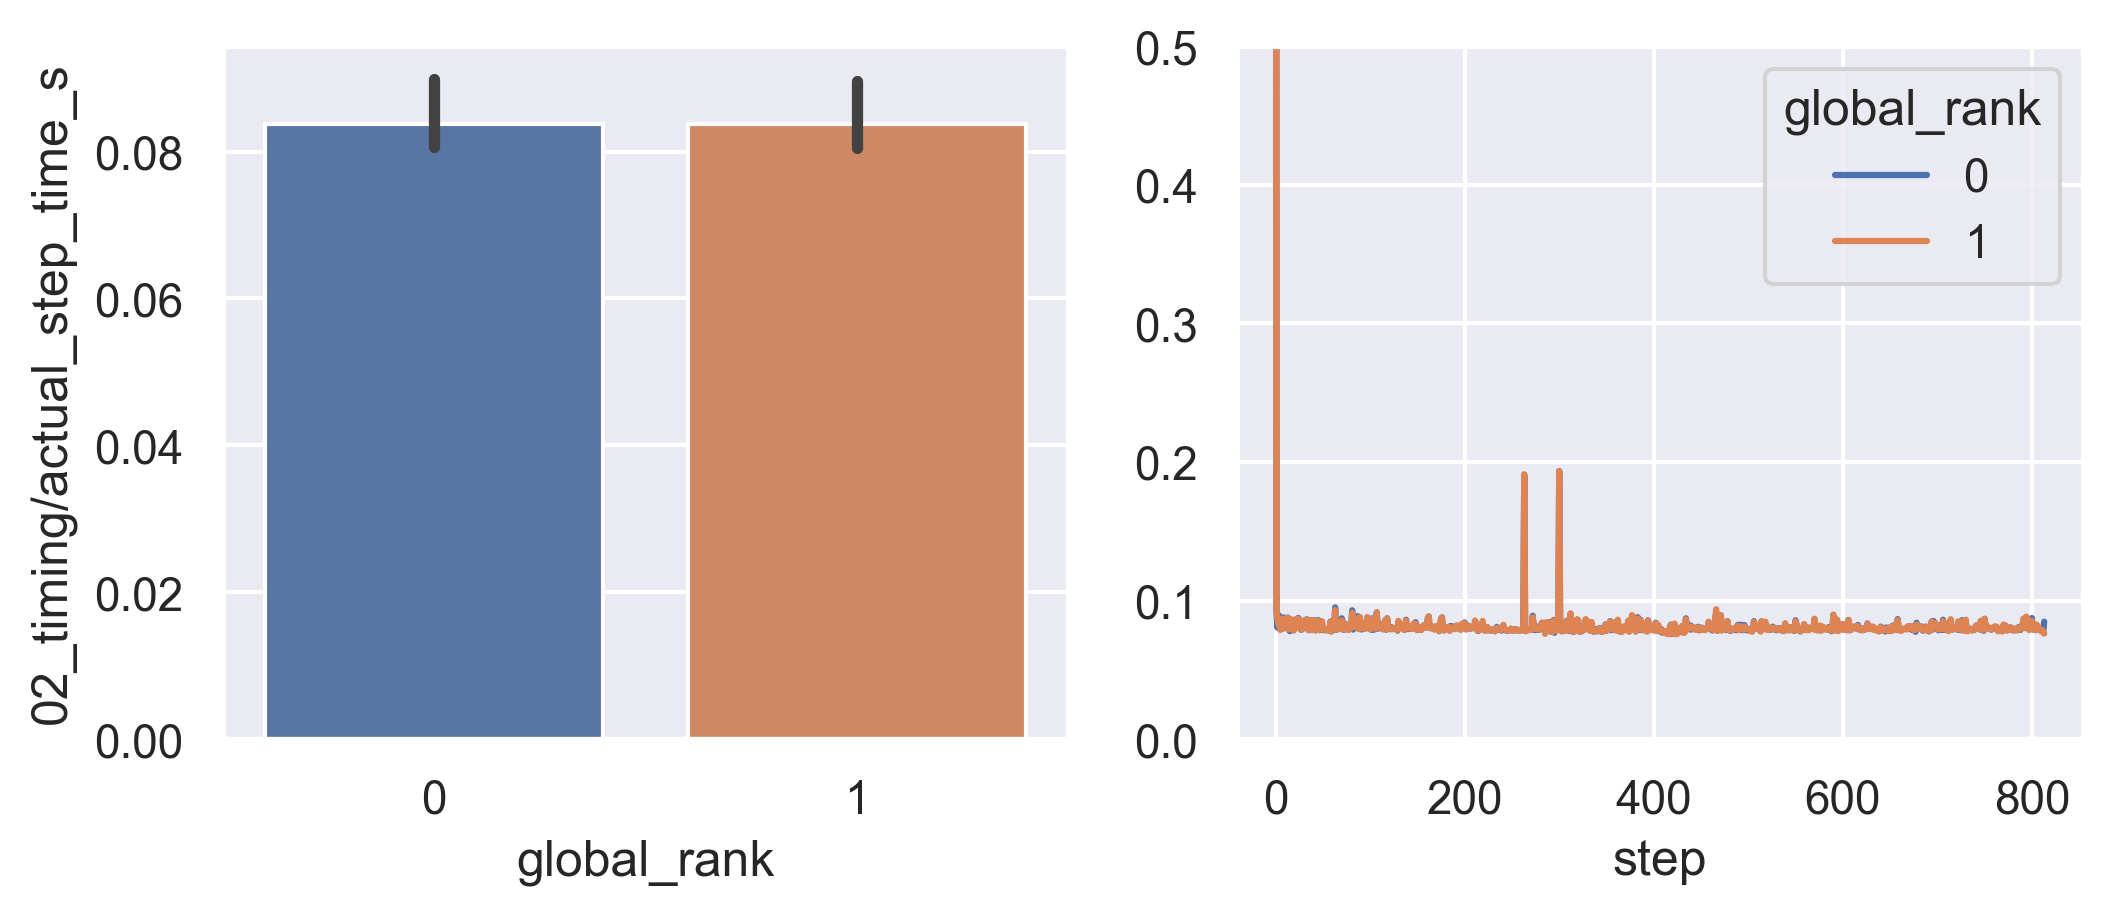

In [224]:
def dual_plot(df, x, y, line_ylim):
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    fig = sns.barplot(
        data=df,
        x=x,
        y=y,
        ax=ax[0])
    fig = sns.lineplot(
        data=df,
        x="step",
        y=y,
        ax=ax[1],
        hue=x)
    ax[1].set_ylabel("")
    ax[1].set_ylim(line_ylim)

x = "global_rank"
y = "02_timing/actual_step_time_s"
dual_plot(df=test_run, x=x, y=y, line_ylim=[0,0.5])